In [2]:
import torch 
from torch import nn 
import pandas as pd
from torch import optim 
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms 
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import numpy as np 
import random 
import timeit
from tqdm import tqdm

So the flow is:
Transformer Encoder outputs (batch_size, num_patches + 1, embed_dim).

You select the first token (CLS):
```
cls_token = output[:, 0, :]
```
→ shape (batch_size, embed_dim)

Then apply:

LayerNorm (normalize each embed_dim vector independently)

Linear (map to num_classes)

So the flow is:
Transformer Encoder outputs (batch_size, num_patches + 1, embed_dim).

You select the first token (CLS):
```
cls_token = output[:, 0, :]
```
→ shape (batch_size, embed_dim)

Then apply:

LayerNorm (normalize each embed_dim vector independently)

Linear (map to num_classes)

So the flow is:
Transformer Encoder outputs (batch_size, num_patches + 1, embed_dim).

You select the first token (CLS):
```
cls_token = output[:, 0, :]
```
→ shape (batch_size, embed_dim)

Then apply:

LayerNorm (normalize each embed_dim vector independently)

Linear (map to num_classes)

So the flow is:
Transformer Encoder outputs (batch_size, num_patches + 1, embed_dim).

You select the first token (CLS):
```
cls_token = output[:, 0, :]
```
→ shape (batch_size, embed_dim)

Then apply:

LayerNorm (normalize each embed_dim vector independently)

Linear (map to num_classes)

### ViT Architecture from the 16x16 words paper

![vit_architecture](ViT_architecture.png)
 

In [3]:
## Added Params (for training and testing)
RANDOM_SEED = 42
BATCH_SIZE = 512 
EPOCHS = 40 ##why this high number? usually for transformers you do 1,2,3. 

##
LEARNING_RATE = 1e-4
NUM_CLASSES = 10 #because MNIST
PATCH_SIZE = 4 #we chose 4-> pixel length of 1 dimension
IMAGE_SIZE = 28 #The MNIST dataset images are 28 × 28 pixels in size. (H,W) = (28, 28) 
IN_CHANNELS = 1 #MNIST only has 1 channel (Grayscale). Note: RGB would be 3 channels. 
NUM_HEADS = 8 #Within the transformer encoder there are attention heads- we choose 8 of them.                           
DROPOUT = 0.001 
HIDDEN_DIM = 768 #hidden dimentsion of MLP head for classification 
ADAM_WEIGHT_DECAY = 0 # paper uses 0.1, set it to 0 (defautl value)
ADAM_BETAS = (0.9, 0.999) # again from paper. 

ACTIVATION = "gelu" #again use the same as the paper 
NUM_ENCODER = 4 #stack encoders on top of each other (architecture just shows one)


##This is the input size to the patch embedding layer (aka flattening image into sequence of patches )
EMBED_DIM = (PATCH_SIZE**2) * IN_CHANNELS # 16 -> basically the number of patches

## Paper defines the below as: N =HW / P^2
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2 # 49


random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


device = "cude" if torch.cuda.is_available() else "cpu"

In [18]:
#OVERWRITE PARAMS TO TRAIN ON MY COMPUTER
BATCH_SIZE = 512 #change to 256 if memory cant handle 512
EPOCHS = 3
NUM_HEADS = 4
HIDDEN_DIM = 128
NUM_ENCODER = 2

## Quick Check in on [CLS] Token and Positional Embeddings 

In ViT: 
- split image into patches and turn them into embeddings (1 patch = 1 embedding vector)
- model pretends that the patches are a sequence of tokens, just like words in NLP models like BERT

2 Important points : 
1) prepend a special [CLS] token (like "classification token") at the start of the sequence.
2) add positional embeddings to every token (patches and the [CLS] token) so the model knows the order.

# Example:
1) After patch embedding, suppose we have: 
- 100 patches, where each patch is an embedding vector of size D (say, 768)
- so our sequence has shape: (100,768)

2) Create [CLS] token 
- Create a new learnable vector (randomly initialized) of size D, called the [CLS] token -> just another vector like a patch but it doesn't come from the image

3) Prepend the [CLS] token
- now sequence becomes: (1+100,768)
- where First position: [CLS] token & Next positions: patch tokens

4) Add Positional Embeddings 
- Transformers have no sense of order natively, so you add (element-wise) a positional embedding vector to each token
- The [CLS] token gets a positional embedding for position 0.
-  Patch tokens get positional embeddings for positions 1, 2, 3, ..., 100.
- Now the model knows which patch is where.

In [19]:
# Creating CLS Tokens and merging with Positional Embeddings 

class PatchEmbedding(nn.Module):
    def __init__(self, embedding_dim, patch_size, num_patches, dropout, in_channels): 
        super().__init__()
        
        #function that divides images into patches
        self.patcher = nn.Sequential(
            # all Conv2d does is divide our image into patch sizes
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embedding_dim,
                kernel_size=patch_size,
                stride=patch_size,
            ), 
            nn.Flatten(start_dim=2)) #equivalent to nn.Flatten(start_dim=2, end_dim=-1) -> not a learnable layer (converts patched into sequence of vectors)
        
            #OUTPUT SHAPE: (batch_size, embedding_dim, num_patches) AKA the full sequence of patches
            
        
        #---- CLS Token ---- 
     
        #here we define the [CLS] token. nn.Parameter is a learnable tensor (its a single parameter not a full layer)
        # Create a random tensor of shape (1, in_channels, embedding_dim), wrap it as a learnable parameter, and assign it as the CLS token
        self.cls_token = nn.Parameter(torch.randn(size=(1,in_channels,embedding_dim)), requires_grad=True)
        
        
        #---- Positional Embedding ---- 
        
        
        #positional embedding is a learnable parameter 
        self.position_embedding = nn.Parameter(torch.randn(size=(1,num_patches+1,embedding_dim)), requires_grad=True) #we add 1 to num_patches because we have the [CLS] token
        
        self.dropout = nn.Dropout(dropout)
    
    
    #after patching and flattening we have a tesnor of shape (batch_size, embedding_dim, num_patches) e.g., (32, 16, 49)
    # x = x.permute(0, 2, 1) rearranges to (batch_size, num_patches, embedding_dim) e.g., (32, 49, 16)
        
        
        
        
    def forward(self, x): 
        #here we expand the cls token so its not just the shape for 1 sample but for a batch of images
        cls_token = self.cls_token.expand(x.shape[0], -1, -1) #expand the cls token to the batch size. x.shape[0] is the batch size. -1, -1 tells expand function to keep original dimensions. 
        x = self.patcher(x).permute(0,2,1) # first patch x through patcher -> where nn.Conv2d: splits x into patches and embeds them, nn.Flatten(start_dim=2) converts into 1D sequence
        
        #1 axis for batches, 1 axis for sequence of patches, 1 axis for embedding dimension 
        x = torch.cat([cls_token, x], dim=1) #so we want to add the CLS token to the left of the patches
        
        #then we need to add the position tokens to each patch 
        x = self.position_embedding + x
        
        x = self.dropout(x)
        return x


#always test model after you define it    
model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS).to(device)  
x = torch.randn(512, 1, 28, 28).to(device)   #create dummy image of batch size 512, channels 1, and dimensions 28x28 
print(model(x).shape) #expect (512, 50, 16) where batch size 512, 50 is number of tokens we feed transformer (correct because we have 49 patches + CLS token), 16 is size of patches (embedding dimension)

torch.Size([512, 50, 16])


Note: nn.Sequential is a convenience container in PyTorch.
It lets you stack layers together in order, without writing a full forward() method manually.

Instead of writing:
 ```python
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(10, 20)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(20, 5)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x
```
You can do the same thing with nn.Sequential:

```python

model = nn.Sequential(
    nn.Linear(10, 20),
    nn.ReLU(),
    nn.Linear(20, 5)
)
```

Notes on the layers:

-  nn.Conv2d is a layer in PyTorch (torch.nn) used for applying a 2D convolution over an input, typically an image.
    It slides filters (kernels) over a 2D input (like an image) and computes feature maps.
- nn.Flatten() reshapes a tensor by flattening part of its dimensions into a single one.
     Turns multi-dimensional data (like 2D or 3D feature maps) into a 1D vector per sample, usually before feeding it into fully connected (Linear) layers.

Notes on cls_token:
- shape is: 1 × in_channels × embedding_dim
    - 1 -> Becaues we only have one CLS token per sample
    - in_channels × embedding_dim -> to match the dimensions of the patch embedding vector because we add it to the sequence before feeding into the transformer.
    - another note on the 1, it is a batch-size like-dimenssion, and we replace it with the batch size
    
    
- why have it? 
    - CLS token = Learnable summary of the whole input.
    - It acts as a summary token: after going through the transformer layers, the model will read the CLS token to decide the final class label.
    - Think of it like a "learnable prompt" — the model writes its summary into it during training.
    

Tracking the shapes:

You start with an image of shape:
(batch_size, in_channels, height, width) = (32, 1, 28, 28)


then we apply patcher 

```
self.patcher = nn.Sequential(
    nn.Conv2d(in_channels, embedding_dim, patch_size, stride=patch_size),
    nn.Flatten(start_dim=2)
)

```
where nn.Conv2D divides the image into patches of size 4×4 pixels so we get: 
(batch_size, embedding_dim, height//patch_size, width//patch_size) = (32, 16, 7, 7)
     where: 
     - 28 // 4 = 7 patches along height
     - 28 // 4 = 7 patches along width
     - 16 filters = 16 features per patch
    
Apply nn.Flatten(start_dim=2), which Flatten from dimension 2 onward:
- Flatten (7,7) together into 49, so after flattening:
- (batch_size, embedding_dim, num_patches) = (32, 16, 49)

Quick notes on below:
- We implemented our encoder block using pytorch but we're meant to explicitely code it out -> I will do this after doing one full iteration

In [20]:
class ViT(nn.Module):
    def __init__(self, num_patches, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels) #call the class we trained earlier -> this will give us the input to our encoder (divide image into patches and generate sequences)
        
        
        #---- ENCODER ---- 
        #PyTorch version:
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True) # we defined our images so that batch size comes first, so we should add: batch_first=True 
        
        #above is only one encoder layer, we're stacking many encoder layers:
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)
        
        #---- MLP HEAD ---- 
        # The ViT typically uses only the [CLS] token for classification
        
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim), #normalise each sequence with itself 
            nn.Linear(in_features=embed_dim, out_features=num_classes) #since we are doing classification, output features is number of classes (10 in our case)
        )

    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :]) #we dont classify the whole embedding, instead we classify the CLS token in the beginning because its a learnable parameter and its meant to contain all the information the other parameters have
        return x 

model = ViT(NUM_PATCHES, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODER, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)  
x = torch.randn(512, 1, 28, 28) #dummy image
print(model(x).shape) #expect [512, 10] -> batch of 512 (512 images) for 10 classes -> returns a probability distribution over 10 classes

/Users/korirogers/.pyenv/versions/3.10.4/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([512, 10])


So the flow is:
Transformer Encoder outputs (batch_size, num_patches + 1, embed_dim).

You select the first token (CLS):
```
cls_token = output[:, 0, :]
```
→ shape (batch_size, embed_dim)

Then apply:

LayerNorm (normalize each embed_dim vector independently)

Linear (map to num_classes)

In [21]:
#Download MNIST dataset 

transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


#Convert to Pandas dataframe 
# Train
train_images = train_dataset.data.view(-1, 28*28).numpy()  # flatten images
train_labels = train_dataset.targets.numpy()               # labels

train_df = pd.DataFrame(train_images)
train_df['label'] = train_labels  # add labels at the end

# Test
test_images = test_dataset.data.view(-1, 28*28).numpy()
test_labels = test_dataset.targets.numpy()

test_df = pd.DataFrame(test_images)
test_df['label'] = test_labels

In [22]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [23]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [24]:
#split train data into train and validation sets 
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)

In [25]:
#Need 3 separate dataset objects: train, val, test 


#---- TRAIN DATASET ---- 

class MNISTTrain(Dataset):
#since this is a pytorch dataset we definitely need init, len, and getitem
    def __init__(self, images, labels, indices):
        self.images = images # the pixel data (e.g., from your train_df).
        self.labels = labels # the ground truth labels (0–9).
        self.indices = indices # which rows of the dataframe to use
        
        
        #define the transformations we want to apply to the images
        self.transforms = transforms.Compose([
            transforms.ToPILImage(), #	Convert tensor into a PIL Image so we can apply image transformations like rotation.
            transforms.RandomRotation(15), #Randomly rotate the image by up to ±15 degrees 
            transforms.ToTensor(), # 	Convert back from PIL Image to a PyTorch Tensor
            transforms.Normalize([0.5], [0.5]) #Normalize the image to have zero mean and unit variance
        ])
        #we apply random rotation to make the model more robust to rotation, and normalize the image to have zero mean and unit variance so that model converges faster
        # All these transformations are automatically applied every time you load a sample from the dataset!
        
        #IMPORTANT: only apply transforms to the training set, not the validation or test set
        
    #when we call len it returns the number of samples in the dataset
    def __len__(self):
        return len(self.images)

    #when we call getitem it returns the sample at index idx
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28,28)).astype(np.uint8) #we reshape the image to 28x28 (MNIST images are 28x28) and convert to uint8 to be able to apply the transformations
        label = self.labels[idx]
        index = self.indices[idx]
        
        image = self.transforms(image) #we need to apply the transformations to the image

        return {'image': image, 'label': label, 'index': index} #return a dictionary with the image, label, and index -> this is the train dataset object
    
    
#---- VALIDATION DATASET ---- 

class MNISTVal(Dataset):
    def __init__(self, images, labels, indices):
        self.images = images
        self.labels = labels
        self.indices = indices
        
        self.transforms = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize([0.5], [0.5]) 
        ])
    
    #no transformations needed for validation set because we want the pure results of the dataset with augmentation -> however we can apply normalisation because at inference time, applying normalisation is fine. But applying augementation may harm results. 
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28,28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indices[idx]
        image = self.transforms(image) 
        
        return {'image': image, 'label': label, 'index': index}
        

class MNISTTEst(Dataset):
    def __init__(self, images, indices):
        self.images = images
        self.indices = indices
        
        self.transforms = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize([0.5], [0.5]) 
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28,28)).astype(np.uint8)
        index = self.indices[idx]
        image = self.transforms(image) 
        
        return {'image': image, 'index': index}

54000
{'image': tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0

<Figure size 640x480 with 0 Axes>

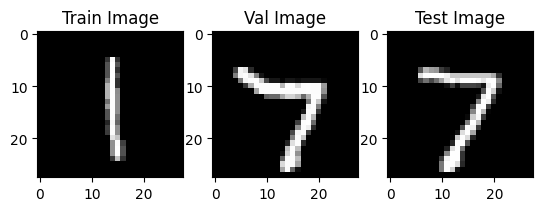

In [26]:
#lets test our datasets (just like we tested our models)

#plot samples from dataset
plt.figure() #creates new empty figure for our plots 
f, axarr = plt.subplots(1, 3) #creates a 1x3 grid of subplots, f is the figure and axarr is an array of axes (subplots) -> one subplot for each train, test, val set. 

train_dataset = MNISTTrain(
    images=train_df.iloc[:, :-1].values.astype(np.uint8), #we drop the last column (labels) and convert to uint8
    labels=train_df['label'].values,
    indices=train_df.index.values
)

#check if len works 
print(len(train_dataset))

#check if getitem works 
print(train_dataset[0])

#show image of data-set 
axarr[0].imshow(train_dataset[0]['image'].squeeze(), cmap='gray')
#note, we know we can access via ['image'] cos we defined it in the dataset class above here: return {'image': image, 'label': label, 'index': index}

axarr[0].set_title(f"Train Image")

print("-"*30)


val_dataset = MNISTVal(
    images=val_df.iloc[:, :-1].values.astype(np.uint8), 
    labels=val_df['label'].values,
    indices=val_df.index.values
)

print(len(val_dataset))
print(val_dataset[0])
axarr[1].imshow(val_dataset[0]['image'].squeeze(), cmap='gray')
axarr[1].set_title(f"Val Image")
print("-"*30)


#removed the labels from the test set
test_dataset = MNISTTEst(
    images=test_df.iloc[:, :-1].values.astype(np.uint8), 
    indices=test_df.index.values
)


print(len(test_dataset))
print(test_dataset[0])

axarr[2].imshow(test_dataset[0]['image'].squeeze(), cmap='gray')
axarr[2].set_title(f"Test Image")

print("-"*30)

In [27]:
## Define our Dataloaders
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [29]:
#Now we get into training loop 

#define loss function and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY, betas=ADAM_BETAS)

#lets estimate the time it will take to train the model 
start = timeit.default_timer()


#we add 2 more parameters to the tqdm function: position and leave. 
for epoch in tqdm(range(EPOCHS), position =0, leave=True):
    model.train() #take the model into train mode 
    
    #we need to store train labels and predictions for a given epoch so we can calculate the loss and accuracy for that epoch so we initialise empty lists 
    train_labels = [] 
    train_preds = []
    train_running_loss = 0.0 #store runnign losss which will start at 0
     
    #iterate through data loader 
    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        #remember we return 'image' from dataset class and its a dataframe which is accessible like a dictionary
        img = img_label['image'].float().to(device)
        label = img_label['label'].type(torch.uint8).to(device) # remember MNIST labels are always integers between 0–9 (digits) so we store as int
        y_pred = model(img)
        
        #recall the output shape is (batch_size, num_classes) aka ([512, 10]), which is a probability distribution over the 10 classes -> so we need to get the index of the highest probability
        
        
        #to predict the label: 
        y_pred_label = torch.argmax(y_pred, dim=1) #take the column with the highest probability and select it -> dim 1 instead of 0 because we look across the rows of [512, 10] which is the classes
        
        #add to train labels. store to cpu when we can to avoid using up GPU memory 
        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())
        
        #3 lines below ensure that training is happening 
        
        loss = criterion(y_pred, label) #calculate the loss -> returns a scalar tensor
        optimizer.zero_grad() #zero the parameter gradients
        loss.backward() #backpropagate the loss
        optimizer.step() #update the model parameters
        
        #update the loss 
        train_running_loss += loss.item() #stores the loss for all batches in the epoch
    
    #now we update the train loss for the whole epoch     
    train_loss = train_running_loss / len(train_dataloader) #stores the loss for 1 epoch -> average the loss over the number of batches in the epoch. so we have average loss per batch for 1 epoch. len(train_dataloader) = number of batches in the epoch
    
    
    #calculate train accuracy (num of correct predictions / total num of predictions)
    train_acc = sum(x == y for x, y in zip(train_labels, train_preds)) / len(train_labels)

        
    
    
    #take model into evaluation mode 
    model.eval()
    val_labels = [] #store validation labels for a given epoch 
    val_preds = [] #store validation predictions for a given epoch 
    val_running_loss = 0.0 #store running loss for a given epoch 
    
    #no need to track gradients in validation loop aka ensures no learning is happening in validation loop -> since we just want validation score from trained model 
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label['image'].float().to(device)
            label = img_label['label'].type(torch.uint8).to(device)
            y_pred = model(img)
            
            y_pred_label = torch.argmax(y_pred, dim=1)
            
            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())
            
            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
    val_loss = val_running_loss / len(val_dataloader)
    val_acc = sum(x == y for x, y in zip(val_labels, val_preds)) / len(val_labels)

            
     #print as train happens 
    print("-"*30)
    print(f"Train loss EPOCH {epoch+1}: {train_loss:.4f}")       
    print(f"Val loss EPOCH {epoch+1}: {val_loss:.4f}")
    print(f"Train acc EPOCH {epoch+1}: {train_acc:.4f}")
    print(f"Val acc EPOCH {epoch+1}: {val_acc:.4f}")
    print("-"*30)
    
stop = timeit.default_timer() 
print(f"Time taken: {stop - start:.2f} seconds")

 33%|███▎      | 1/3 [03:13<06:27, 193.64s/it]

------------------------------
Train loss EPOCH 1: 2.3052
Val loss EPOCH 1: 2.2863
Train acc EPOCH 1: 0.1154
Val acc EPOCH 1: 0.1747
------------------------------


 67%|██████▋   | 2/3 [06:28<03:14, 194.38s/it]

------------------------------
Train loss EPOCH 2: 2.0966
Val loss EPOCH 2: 1.8554
Train acc EPOCH 2: 0.2295
Val acc EPOCH 2: 0.3292
------------------------------


100%|██████████| 3/3 [11:53<00:00, 237.70s/it]

------------------------------
Train loss EPOCH 3: 1.6868
Val loss EPOCH 3: 1.4273
Train acc EPOCH 3: 0.4674
Val acc EPOCH 3: 0.6115
------------------------------
Time taken: 713.09 seconds


Outer loop: 
- we loop over epochs

Inner loop: 
- we loop over each batch from the dataloader 


You will see: e.g. 46/106 -> 106 is the number of batches. number of batches = dataset-size/batch-size = (54K) /512 =106 (round up) for train, 6k/512 = 12 (round up) for test. We always round up, last batch may be smaller but we still train on those samples. 